## Step 0: Preparation

In [26]:
%pip install -q fsspec==2024.9.0

Note: you may need to restart the kernel to use updated packages.


In [27]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [28]:
import os
os.environ["RAY_DEDUP_LOGS"] = "0"

In [29]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
# from flwr_datasets import FederatedDataset

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.13.1 / PyTorch 2.5.1+cpu


#### Load dataset and preprocessing

In [30]:
# Khi chạy bằng colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

In [31]:
train_1 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/train_FD001.txt"
# train_1 = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD001.txt"
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_1 = pd.read_csv(train_1, sep=' ', header=None)
train_1.drop([26, 27], axis=1, inplace=True)
train_1.columns = column_names

train_1['Remaining RUL'] = ''

In [32]:
# remaining_rul = max_rul - cycle
max_cycle = train_1.groupby('ID Engine').count()
for idx in range(len(train_1)):
    train_1.loc[idx, 'Remaining RUL'] = max_cycle.loc[train_1.loc[idx, 'ID Engine'], 'Cycle']
train_1['Remaining RUL'] = train_1['Remaining RUL'] - train_1['Cycle']

In [33]:
# train_1 = train_1.drop(['Setting 1','Setting 2', 'Sensor 1', 'Setting 3','Sensor 5','Sensor 6', 'Sensor 10', 'Sensor 16', 'Sensor 18','Sensor 19'], axis=1)
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [34]:
# Normalization
df = train_1.copy()
scaled_columns = df.columns[5:]
scaler = MinMaxScaler()
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])
df.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.205882,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,0.529086
1,1,2,0.0019,-0.0003,100.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.279412,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,0.526316
2,1,3,-0.0043,0.0003,100.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.220588,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,0.523546
3,1,4,0.0007,0.0000,100.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.294118,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,0.520776
4,1,5,-0.0019,-0.0002,100.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.235294,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,0.518006


In [35]:
def split_dataset(dataset, num_clients):
    """
    Chia dataset thành num_clients tập con đều nhau.
    Args:
        dataset: Dataset cần chia (torch.utils.data.Dataset).
        num_clients: Số lượng tập con muốn tạo.
    Returns:
        List chứa các tập con của dataset.
    """
    # Kích thước mỗi tập con
    subset_size = len(dataset) // num_clients
    sizes = [subset_size] * num_clients

    # Chia phần dư (nếu tổng dataset không chia hết)
    sizes[-1] += len(dataset) - sum(sizes)

    # Tạo danh sách các tập con
    subsets = random_split(dataset, sizes)
    return subsets

In [36]:
class FD001DatasetLoader(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []

        grouped = data.groupby('ID Engine')
        for _, group in grouped:
            values = group.drop(['ID Engine', 'Cycle', 'Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values

            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length])
                self.targets.append(rul_values[i + sequence_length - 1])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )


In [37]:
dataset = FD001DatasetLoader(df)
train_data, validation_data = train_test_split(dataset, test_size=0.2, random_state=42)

num_clients = 10
subsets_train = split_dataset(train_data, num_clients)
subsets_validation = split_dataset(validation_data, num_clients)
# Tạo DataLoader cho mỗi tập
client_loader_trains = [DataLoader(subset, batch_size=32, shuffle=True) for subset in subsets_train]
client_loader_validations = [DataLoader(subset, batch_size=32, shuffle=True) for subset in subsets_validation]

# train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [40]:
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=32, shuffle=False)

In [19]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")
    # start_client(train_loader=loader, test_loader=test_loader)

Client 1 will use a subset with 1418 samples
Client 2 will use a subset with 1418 samples
Client 3 will use a subset with 1418 samples
Client 4 will use a subset with 1418 samples
Client 5 will use a subset with 1418 samples
Client 6 will use a subset with 1418 samples
Client 7 will use a subset with 1418 samples
Client 8 will use a subset with 1418 samples
Client 9 will use a subset with 1418 samples
Client 10 will use a subset with 1422 samples


In [20]:
for i, loader in enumerate(client_loader_validations):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")
    # start_client(train_loader=loader, test_loader=test_loader)

Client 1 will use a subset with 354 samples
Client 2 will use a subset with 354 samples
Client 3 will use a subset with 354 samples
Client 4 will use a subset with 354 samples
Client 5 will use a subset with 354 samples
Client 6 will use a subset with 354 samples
Client 7 will use a subset with 354 samples
Client 8 will use a subset with 354 samples
Client 9 will use a subset with 354 samples
Client 10 will use a subset with 361 samples


## Step 1: Centralized Training with PyTorch

#### Define the Transformer model

In [42]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])  # Lấy giá trị cuối
        return output.squeeze(-1)

#### Define train function the model

In [43]:
def train(model, client_loader_train, client_loader_validation: None, epochs: int, verbose=False):
    input_dim = 24
    model = model.to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in client_loader_train:
            seq, target = batch
            seq, target = seq.to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in client_loader_validation:
                seq, target = batch
                seq, target = seq.to(DEVICE), target.to(DEVICE)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(client_loader_train)}, Val Loss = {val_loss / len(client_loader_validation)}")

In [44]:
def predict_on_batch(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()
    # Lấy một vài mẫu dữ liệu từ tập val_loader
    samples, targets = next(iter(client_loader_validation))  # Lấy một batch từ validation set
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    # Dự đoán với model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        predictions = model(samples)  # [batch_size]
    val_loss = criterion(predictions, targets)

    if return_actual_rul:
        # Đưa kết quả về CPU để xử lý
        samples = samples.cpu()
        targets = targets.cpu()
        predictions = predictions.cpu()

        # Đảo chuẩn hóa dữ liệu
        rul_min = scaler.data_min_[-1]
        rul_max = scaler.data_max_[-1]

        # Đưa predictions và targets về dạng thực tế
        actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
        actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

        if show_fig:
            # Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
            plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
            plt.title("Comparison of Predicted and Actual RUL")
            plt.xlabel("Sample Index")
            plt.ylabel("Remaining Useful Life (RUL)")
            plt.legend()
            plt.grid(True)
            plt.show()

        return val_loss, actual_predictions, actual_targets

    return val_loss


In [45]:
def test(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()

    samples, targets = next(iter(client_loader_validation))
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    # Dự đoán với model
    model.eval()
    val_loss = 0
    accuracys = 0
    with torch.no_grad():
      for batch in client_loader_validation:
        samples, targets = batch
        samples, targets = samples.to(DEVICE), targets.to(DEVICE)
        predictions = model(samples)
        val_loss += criterion(predictions, targets).item()
    return val_loss / len(client_loader_validation)


#### Train the model (Centralized Transformer model)

In [48]:
model = TransformerModel(input_dim=24, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(DEVICE)
train(model=model, client_loader_train=train_loader, client_loader_validation=validation_loader, epochs=50)

Epoch 1: Train Loss = 0.04663250212104538, Val Loss = 0.033061708701220716
Epoch 2: Train Loss = 0.033856506201413436, Val Loss = 0.029486277551801356
Epoch 3: Train Loss = 0.03197377574260909, Val Loss = 0.03083986812480935
Epoch 4: Train Loss = 0.031426167868597955, Val Loss = 0.02936184114298305
Epoch 5: Train Loss = 0.03069599628498828, Val Loss = 0.029324218328740145
Epoch 6: Train Loss = 0.03031469609479311, Val Loss = 0.028914225245783996
Epoch 7: Train Loss = 0.03002043141404519, Val Loss = 0.03016120806202158
Epoch 8: Train Loss = 0.02890767291322485, Val Loss = 0.02399046429609125
Epoch 9: Train Loss = 0.0213985745805559, Val Loss = 0.013072135367405575
Epoch 10: Train Loss = 0.015855103331567668, Val Loss = 0.012373625023944958
Epoch 11: Train Loss = 0.01481090274824014, Val Loss = 0.013069895062562044
Epoch 12: Train Loss = 0.014032523510642015, Val Loss = 0.012490534005468493
Epoch 13: Train Loss = 0.013943331432528794, Val Loss = 0.012078992288291186
Epoch 14: Train Loss 

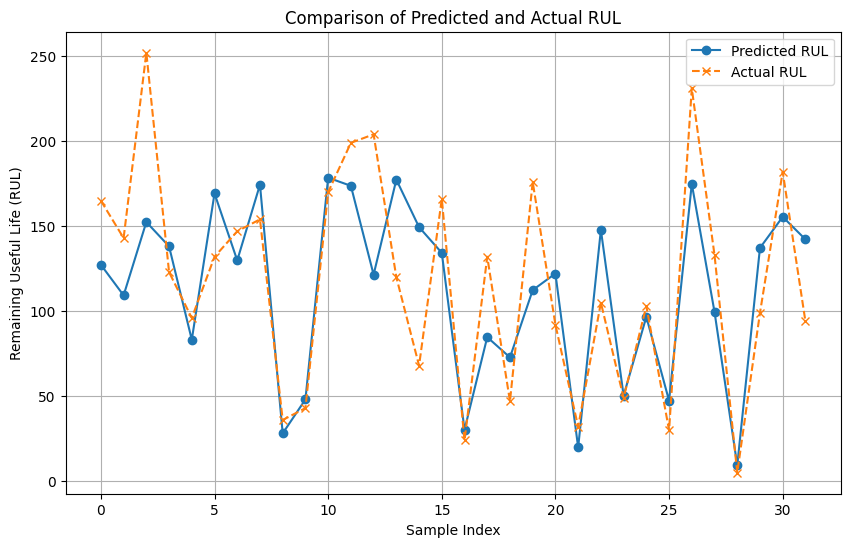

loss=0.0125861382111907
actual rul = [127.309456 109.299225 152.43692  138.11697   83.21238  169.25517
 129.85455  174.40875   28.14295   48.113987 178.50157  173.72084
 121.469955 177.36899  149.42502  134.30954   30.247446  84.73877
  72.816414 112.39686  122.155945  19.876867 147.83649   50.341328
  96.675804  47.373737 174.88843   99.567085   9.366834 137.19455
 155.48738  142.22398 ]
actual target=[165.       143.       252.       123.00001   96.       132.
 147.       154.        36.        43.       170.       199.
 204.00002  120.        68.       166.        24.       132.
  47.       176.        92.        32.       105.        48.999996
 103.        30.       231.       133.         5.        99.
 181.99998   94.      ]


In [20]:
# Dùng tạm validation của client 1 test thử cho model client 0 ở trên!
loss, return_actual_rul, actual_target = predict_on_batch(model=model, client_loader_validation=client_loader_validations[1], return_actual_rul=True, show_fig=True)
print(f'loss={loss}')
print(f'actual rul = {return_actual_rul}')
print(f'actual target={actual_target}')

In [21]:
# Dùng tạm validation của client 1 test thử cho model client 0 ở trên!
loss, return_actual_rul, actual_target = predict_on_batch(model=model, client_loader_validation=client_loader_validations[2], return_actual_rul=True, show_fig=False)
print(f'loss={loss}')
print(f'actual rul = {return_actual_rul}')
print(f'actual target={actual_target}')

loss=0.008745996281504631
actual rul = [177.03487  149.16402   26.93405  116.190445  97.89714  160.66489
 152.42049   62.020763 103.00481  179.74168  132.42075  108.39973
 164.11163  168.95444  121.46576  159.71886   63.51032  147.42442
 111.13244  136.97395  171.33585  132.72284    3.917282  43.17373
 148.83878   47.593323 118.84436   41.254726  53.26817  180.65677
 150.30733   84.47442 ]
actual target=[198.       138.        46.       117.        77.       183.
 254.        65.       148.       146.        96.       157.
 151.       192.        73.       126.        44.       129.
  92.       134.       116.00001  119.         1.        29.000002
 110.        31.        60.        63.        17.       213.99998
 163.        65.      ]


## Step 2: Federated Learning with Flower

#### Update model parameters

In [22]:
def set_parameters(model, parameters: List[np.ndarray]):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

def get_parameters(model) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

#### Define the Flower ClientApp

In [23]:
class FlowerClient(NumPyClient):
    def __init__(self, model, client_loader_train, client_loader_validation):
        self.model = model
        self.trainloader = client_loader_train
        self.valloader = client_loader_validation

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        train(
            model=self.model, 
            client_loader_train=self.trainloader, 
            client_loader_validation=self.valloader, 
            epochs=1
        )
        return get_parameters(self.model), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        # loss, accuracy = test(self.model, self.valloader)
        loss = test(
            model=self.model,
            client_loader_validation=self.valloader,
            return_actual_rul=False,
            show_fig=False
        )
        return float(loss), len(self.valloader), {"accuracy": float(0.0)}

In [24]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    model = TransformerModel(
        input_dim=24, 
        d_model=64, 
        nhead=4, 
        num_layers=2, 
        dim_feedforward=256, 
        dropout=0.1
    ).to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader = client_loader_trains[partition_id]
    valloader = client_loader_validations[partition_id]

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(model, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

#### Define the Flower ServerApp

In [25]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [26]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=50)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

#### Run the training

In [27]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
# if DEVICE.type == "cuda":
#     backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [28]:
# Run simulation
NUM_CLIENTS = 10
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=8182) 2024-12-01 14:05:24.241367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=8182) 2024-12-01 14:05:24.375513: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=8182) 2024-12-01 14:05:24.401652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=8183) 2024-12-01 14:05:24.617213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable 

(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.06702443286776542, Val Loss = 0.03136545326560736
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.06522805678347747, Val Loss = 0.017509301309473813
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.061926223213473956, Val Loss = 0.02812960014368097
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.06723579226268663, Val Loss = 0.020762868458405137
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.06335160202450223, Val Loss = 0.019560694345273077
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.06532438525723086, Val Loss = 0.017892209580168128
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.07379029939572017, Val Loss = 0.020107043363774817
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.0694171348379718, Val Loss = 0.025018886585409444
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.060400086061822046, Val Loss = 0.02996656686688463


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.06101670877801047, Val Loss = 0.017941658617928624


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.042574651539325714, Val Loss = 0.016486114744717877
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.043679455667734145, Val Loss = 0.015125479840207845
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.04315441793037785, Val Loss = 0.01701765980881949
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.041907303325004044, Val Loss = 0.014171953623493513
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.04068026232222716, Val Loss = 0.018708869193991024
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.03696618986626466, Val Loss = 0.014002289584216973
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.04441271958251794, Val Loss = 0.019649374453971784
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.04130997562574016, Val Loss = 0.014388054143637419


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.046685298987560804, Val Loss = 0.017190606178094942
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.0410623949021101, Val Loss = 0.031554885751878224


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.03064058700369464, Val Loss = 0.015617538942024112
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.03303438288470109, Val Loss = 0.015201809098167965
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.035301768531401954, Val Loss = 0.017458613806714613
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.035300262893239655, Val Loss = 0.014862183015793562
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.031631693202588296, Val Loss = 0.013536170745889345
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.03113839460743798, Val Loss = 0.015296350698918104
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.03240601163771417, Val Loss = 0.020236645980427664
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.03453731261607673, Val Loss = 0.018301507690921426
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.033900598684946694, Val Loss = 0.013241483053813377


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.03124014147453838, Val Loss = 0.012425218049126366


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.024887322779330943, Val Loss = 0.010863712416418517
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.029428724406494036, Val Loss = 0.01593129169001865
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.032374997188647586, Val Loss = 0.01288981867643694
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.026810144219133587, Val Loss = 0.012742902166792192
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.0262304006351365, Val Loss = 0.015032641512031356
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.025895770515004794, Val Loss = 0.01547648455016315
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.029126939529346096, Val Loss = 0.01231732494973888
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.02709090809027354, Val Loss = 0.019948183558881283
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.027314719371497632, Val Loss = 0.012740334301876525


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.027886980668538147, Val Loss = 0.01537090155761689


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.02748446690125598, Val Loss = 0.011795303939531246
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.02492441317687432, Val Loss = 0.010995589623538157
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.024142634351220396, Val Loss = 0.012467783720542988
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.022314138462146124, Val Loss = 0.019758921504641574
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.022058898251917626, Val Loss = 0.012700513781358799
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.024153420308397875, Val Loss = 0.01830297987908125
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.023712012709842786, Val Loss = 0.02201474504545331
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.024329841550853517, Val Loss = 0.014157789565312365
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.026364770241909558, Val Loss = 0.011200905855124196


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.026223716822763286, Val Loss = 0.01553433551453054


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.02117650428165992, Val Loss = 0.013695316078762213
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.023095695032841628, Val Loss = 0.01817823275147627
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.022366798172394436, Val Loss = 0.014071983440468708
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.02121742359466023, Val Loss = 0.01132432093618263
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.02248909564481841, Val Loss = 0.013966099824756384
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.022618390205833647, Val Loss = 0.014670660719275475
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.021922917974491914, Val Loss = 0.011602049188998839
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.02167952592588133, Val Loss = 0.012293440250990292


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.024110175151791837, Val Loss = 0.011687585191490749
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.02254315774059958, Val Loss = 0.018784682188803952


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01975121773365471, Val Loss = 0.010292858583852649
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.021636881969041295, Val Loss = 0.011826274334453046
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.0204288378978769, Val Loss = 0.015815523142615955
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.02055676088978847, Val Loss = 0.013257401956555745
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.019719976662761634, Val Loss = 0.01384877844247967
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.02193651625679599, Val Loss = 0.012008188175968826
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01933674623982774, Val Loss = 0.013801588395532841
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.021554428566661146, Val Loss = 0.01220849393090854
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.019792892763184175, Val Loss = 0.011292336188489571


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.021041517704725267, Val Loss = 0.011778702572579883


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01862261849972937, Val Loss = 0.014567704522050917
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.02139490268503626, Val Loss = 0.011005551677953918
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.019688376639452245, Val Loss = 0.012793186974401275
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.019044465157720777, Val Loss = 0.01249836067048212
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01820121251253618, Val Loss = 0.013059481706780693
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01923866371313731, Val Loss = 0.013588177350660166
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01966363965637154, Val Loss = 0.011599308423077067
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.019783050090902383, Val Loss = 0.010994168502899507
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.019960244682927928, Val Loss = 0.014757497701793909


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.018484835274931458, Val Loss = 0.012296733174783489


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.018211626613305675, Val Loss = 0.010625021648593247
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.019427804090082646, Val Loss = 0.014771193304720024
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01795416564370195, Val Loss = 0.012014970047554622
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01855426107843717, Val Loss = 0.011121083865873516
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.018130165421300463, Val Loss = 0.011601753338860968
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01697365544322464, Val Loss = 0.012852217730445167
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.017921143025159837, Val Loss = 0.01370878548671802
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.017348665268056923, Val Loss = 0.011401043254105995
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.018741058247784773, Val Loss = 0.013445686698105419


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.017436106420225566, Val Loss = 0.012956275915106138


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.019213089222709336, Val Loss = 0.012237523643610379
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.017384801101353434, Val Loss = 0.010342193262962004
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.017522427274121177, Val Loss = 0.011187722756100507
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.017767456587817934, Val Loss = 0.01397441967856139
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.017679000759704244, Val Loss = 0.011729679342048863
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01681604257060422, Val Loss = 0.015105369267985225
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.018670117110013963, Val Loss = 0.011701725656166673
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01846839346819454, Val Loss = 0.013843495359954735


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01604253767679135, Val Loss = 0.01235138310585171
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.017648834300537906, Val Loss = 0.011563145710776249


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.018740996004392704, Val Loss = 0.01096904039150104
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.016588881384167406, Val Loss = 0.01042711571790278
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.017386197567813927, Val Loss = 0.019634692308803398
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.017142288552390205, Val Loss = 0.011142371726843217
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01631263035039107, Val Loss = 0.013014601698766151
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.016510430537164212, Val Loss = 0.012823349252964059
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.017472172818250125, Val Loss = 0.013092865759972483
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01792005238433679, Val Loss = 0.011173399048857391
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.017218755475348898, Val Loss = 0.011850257559369007


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.016344993458025984, Val Loss = 0.011449995489480594


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.017149268670214546, Val Loss = 0.01109713587599496
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.016131233899957603, Val Loss = 0.012294407468289137
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.0162654685580896, Val Loss = 0.011738563975086436
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.017853040775905053, Val Loss = 0.011000268976204097
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.016414219265182814, Val Loss = 0.014798677565219501
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.015057558897468779, Val Loss = 0.011055502497280637
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01791841789252228, Val Loss = 0.012049382940555612
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.0174053356051445, Val Loss = 0.01141260847604523
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.016620540846553115, Val Loss = 0.01263748660373191


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.016023242846131325, Val Loss = 0.012013839712987343


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.016181919703053105, Val Loss = 0.011070052608071515
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.017511231990324127, Val Loss = 0.010757430990148956
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01629490252170298, Val Loss = 0.010882489538441101
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.016503597361346087, Val Loss = 0.01102827788660458
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015677991230040787, Val Loss = 0.011749759937326113
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014684736759712299, Val Loss = 0.01463927006504188
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014744522888213396, Val Loss = 0.010796845201790953
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.016136375731892055, Val Loss = 0.013205646925295392
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014969107405179077, Val Loss = 0.010743246725269273


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014861715181420246, Val Loss = 0.011797983975460133


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.017737313670416675, Val Loss = 0.012228842630671958
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014773083188467555, Val Loss = 0.009886771246480444
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.016551341147472462, Val Loss = 0.010748433414846659
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01633104590906037, Val Loss = 0.010848363861441612
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015281979056696097, Val Loss = 0.013431668591996035
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014566106763150956, Val Loss = 0.011016712329971293
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.016764813734011518, Val Loss = 0.01239576211567813
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01531952280137274, Val Loss = 0.011451512497539321
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015210516874988873, Val Loss = 0.012937539645160237


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01714404412648744, Val Loss = 0.012803848134353757


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014997202954772446, Val Loss = 0.014941384006912509
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01688518195102612, Val Loss = 0.013393446757011892
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.015087127809723218, Val Loss = 0.012528812202314535
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01447895270668798, Val Loss = 0.01360605121590197
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014464010018855333, Val Loss = 0.012401276268064976
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013884410872641537, Val Loss = 0.0114947649029394
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.015406234531352918, Val Loss = 0.01279801995648692
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01601314427745011, Val Loss = 0.017273256788030267
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.015235315677192477, Val Loss = 0.011448138005410632


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015500930117236243, Val Loss = 0.011260795989073813


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014639983967774444, Val Loss = 0.010256379066656033
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01519410243878762, Val Loss = 0.014008273215343555
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01499045720944802, Val Loss = 0.012168033242536088
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015832697838130926, Val Loss = 0.010588557071362933
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014370439594818487, Val Loss = 0.013900179338331023
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015854029595437975, Val Loss = 0.012165701249614358
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.0149197770593067, Val Loss = 0.010249673088158792
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.016460275443063842, Val Loss = 0.010653177392669022
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.015624866106857855, Val Loss = 0.011263373075053096


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01530528108899792, Val Loss = 0.010917176608927548


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.015220650140610007, Val Loss = 0.011396553095740577
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013929745979193183, Val Loss = 0.010241199983283877
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014252267208778195, Val Loss = 0.01889517856761813
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015300833878831731, Val Loss = 0.010134259394059578
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014460715423855517, Val Loss = 0.01367863353031377
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014486530133419566, Val Loss = 0.011834642520019164
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.017042753597100575, Val Loss = 0.011443354577446977
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01490837950259447, Val Loss = 0.01300309676056107
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013973811382634772, Val Loss = 0.011257879125575224


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014421391021460294, Val Loss = 0.010957994605026519


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.016590801760968235, Val Loss = 0.010784724300416807
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014865506657709677, Val Loss = 0.013383088711028298
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015163629067440827, Val Loss = 0.010234473544793824
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.015033321206768353, Val Loss = 0.011813701984162131
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015004050359129906, Val Loss = 0.014543838701987019
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014407934269143476, Val Loss = 0.011516177017862598
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013844294670141406, Val Loss = 0.012548991711810231
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014684474695887831, Val Loss = 0.014034536861193677
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01411981913778517, Val Loss = 0.011655245810591927


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014239873085170985, Val Loss = 0.012301068985834718


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015104282150665919, Val Loss = 0.01302490197122097
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014801404242300325, Val Loss = 0.010760226286947727
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013949459087517527, Val Loss = 0.012685472417312363
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013829923917849858, Val Loss = 0.011823817117450139
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.0134642805179788, Val Loss = 0.0133240787157168
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01380146596994665, Val Loss = 0.012617993828219673
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01393527700048354, Val Loss = 0.014041363455665609
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015784996665186353, Val Loss = 0.011593042960157618
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.015179081757863363, Val Loss = 0.011303647266079983


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01421254492468304, Val Loss = 0.011318920839888355


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014425785549812846, Val Loss = 0.012710408074781299
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013490192178222869, Val Loss = 0.009214890907363346
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01351411001653307, Val Loss = 0.011116926015044251
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013885139032370514, Val Loss = 0.01057476499894013
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013582599390712049, Val Loss = 0.014208997444560131
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013795691790680091, Val Loss = 0.011748544367340704
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01346346837364965, Val Loss = 0.010526227692025714
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015613877845721113, Val Loss = 0.010530165978707373
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013500484596523974, Val Loss = 0.012462458844917515


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014419097256743245, Val Loss = 0.011379296464535097


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013415691028866503, Val Loss = 0.013762092023777464
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.016113246221923165, Val Loss = 0.012735146408279737
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01432370747336083, Val Loss = 0.012112158758100122
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014010681253340509, Val Loss = 0.013919837462405363
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01358657323030962, Val Loss = 0.01118194703788807
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013784749091913302, Val Loss = 0.015480246782923738
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014737436423699062, Val Loss = 0.010078445416487133
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013949424421621694, Val Loss = 0.011169411761026518
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013278185700376829, Val Loss = 0.010900659137405455


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013688584396408663, Val Loss = 0.01120308010528485


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013768734348316988, Val Loss = 0.012140666813744852
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01379316287736098, Val Loss = 0.011022417379232744
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013419919285095401, Val Loss = 0.011291704528654615
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013412994477483961, Val Loss = 0.011275209680510065
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013509592600166797, Val Loss = 0.013289727231798073
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013334965985268354, Val Loss = 0.01036772588849999
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014842551946640015, Val Loss = 0.010549948667176068
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014705372456875112, Val Loss = 0.011292455485090613
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014146990339375205, Val Loss = 0.011896189030570289


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014761411947094731, Val Loss = 0.013666091448006531


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014058647273729245, Val Loss = 0.013223927778502306
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012991699700554213, Val Loss = 0.012430328022067746
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013197193687988652, Val Loss = 0.014964099662999312
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013641034025284979, Val Loss = 0.011800554736206928
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013080594036728144, Val Loss = 0.010315543935575988
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013452527744488584, Val Loss = 0.012268211382130781
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013129432975418038, Val Loss = 0.011226517846807837
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015268984695689545, Val Loss = 0.010676063302526018
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014433005203803381, Val Loss = 0.010760430479422212


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014069838728755713, Val Loss = 0.011856102850288153


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014126359443697665, Val Loss = 0.012919956430171927
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014342616498470306, Val Loss = 0.012964479741640389
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013219321674356858, Val Loss = 0.0113705158388863
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014373722806986835, Val Loss = 0.009936714069529748
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013453109024299515, Val Loss = 0.012759416558158895
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01342274531101187, Val Loss = 0.012122278877844414
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013089975042061674, Val Loss = 0.013434260074670116
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013078984142177634, Val Loss = 0.01318418288913866
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.015101338943673505, Val Loss = 0.010504073715613535


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012932299574216207, Val Loss = 0.012088500273724398


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01332508818142944, Val Loss = 0.013293529317403832
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.015522925400485594, Val Loss = 0.010485170661316564
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013838186456511418, Val Loss = 0.009794727006616691
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01309450086620119, Val Loss = 0.011727331904694438
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012736165927102168, Val Loss = 0.01354048257538428
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012798455667992432, Val Loss = 0.011801441277687749
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014210111202879084, Val Loss = 0.015465176043411097
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013150894000298447, Val Loss = 0.010899776165994505


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012633648825188477, Val Loss = 0.01181518550341328
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013737341275231706, Val Loss = 0.012682222644798458


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014857303485688237, Val Loss = 0.010635920198789487
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012956755525536007, Val Loss = 0.010127937770448625
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012931373477396037, Val Loss = 0.011765023387852125
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012905614491966035, Val Loss = 0.012221694176939005
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012501597963273525, Val Loss = 0.010463477704130733
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012487354646954272, Val Loss = 0.012888035271316767
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013067464540816016, Val Loss = 0.01359396668461462
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013636083238654666, Val Loss = 0.009987121195687601
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013965113026400407, Val Loss = 0.010190545814111829


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013755567765070333, Val Loss = 0.013197863629708687


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01327208867813978, Val Loss = 0.010032852141497036
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014754379023280409, Val Loss = 0.01057472782364736
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013205273759861786, Val Loss = 0.009927221700005854
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01350317301435603, Val Loss = 0.013026434501322607
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013504864244411389, Val Loss = 0.011027648618134359
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013202910114907556, Val Loss = 0.010381061681982828
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012679619300696585, Val Loss = 0.010684574042291691
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013015395113163524, Val Loss = 0.012408128435102602
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012259776704013348, Val Loss = 0.011448369671901068


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013187259766790601, Val Loss = 0.011055227078031749


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014366533824553092, Val Loss = 0.010266110727873942
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013455682413445578, Val Loss = 0.01057579837894688
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013024961596561803, Val Loss = 0.011395723752987882
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013343993864125676, Val Loss = 0.01082060435631623
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012587960726684994, Val Loss = 0.010507957112470953
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012796704440067213, Val Loss = 0.012077817460522056
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013135240133851766, Val Loss = 0.010071005827436844
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01297516023947133, Val Loss = 0.012725876023372015


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013442726267708673, Val Loss = 0.009326496937622627
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014001244689441389, Val Loss = 0.012851278375213345


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013032352086156607, Val Loss = 0.011329760037673017
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013676416801495684, Val Loss = 0.01213138240079085
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01343882649929987, Val Loss = 0.011137388491382202
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013955254190497928, Val Loss = 0.009596772220296165
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012622612590591113, Val Loss = 0.01182301986652116
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012718810223870808, Val Loss = 0.011082311626523733
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011963323907305796, Val Loss = 0.011330175950812796
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012838660315093066, Val Loss = 0.010322194504624349


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012746158407794105, Val Loss = 0.010708749774494208
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014877444505691529, Val Loss = 0.010705581206517914


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013430005487882429, Val Loss = 0.011631777587657174
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014278011355135177, Val Loss = 0.010897993265340725
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013566180722167094, Val Loss = 0.010897139785811305
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013030409988843732, Val Loss = 0.012076351403569182
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012810134711778826, Val Loss = 0.011065135826356709
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012856073356750939, Val Loss = 0.012749926963200172
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01303438956124915, Val Loss = 0.011778499950499585
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012711265352037218, Val Loss = 0.010607331389716515
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012497444067978196, Val Loss = 0.011850496133168539


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012710425195594628, Val Loss = 0.009115343370164434


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012717376038846042, Val Loss = 0.012894860003143549
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01282452687414156, Val Loss = 0.012903991620987654
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012300096180600425, Val Loss = 0.012094386387616396
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01230465853586793, Val Loss = 0.010746440617367625
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012504453429331382, Val Loss = 0.010814873618073761
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01238760029276212, Val Loss = 0.011821892267713944
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013987743626866075, Val Loss = 0.011749077355489135
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013097635770423544, Val Loss = 0.009708217131750038
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012895070461349354, Val Loss = 0.011881847717935065


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013099367471618785, Val Loss = 0.009074461258326968


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01371226322112812, Val Loss = 0.011701387663682302
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012476731464266777, Val Loss = 0.011891113865810135
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012705847155302763, Val Loss = 0.010917221351216236
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01270882510062721, Val Loss = 0.010886252265966808
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013266232288959954, Val Loss = 0.012559485233699283
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012507925099796719, Val Loss = 0.010395217357048145
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01224624261053072, Val Loss = 0.010382153210230172
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012082722410559655, Val Loss = 0.01069547930577149
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012389098728696505, Val Loss = 0.01286342297680676


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012860621687852673, Val Loss = 0.010183446342125535


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012336975636167659, Val Loss = 0.009897037564466396
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013912197285228306, Val Loss = 0.010717826274534067
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013062696717679501, Val Loss = 0.012068737880326807
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012766628484759067, Val Loss = 0.011163557607991
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01266744607128203, Val Loss = 0.01669402897823602
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012023759302165773, Val Loss = 0.011350500319773952
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013558948433233632, Val Loss = 0.011301954975351691
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012216183191372288, Val Loss = 0.010352692644422254
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013092965042839447, Val Loss = 0.01064134540501982


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012117217946797609, Val Loss = 0.011286319330489883


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014089105557650328, Val Loss = 0.011079038182894388
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01221336078726583, Val Loss = 0.008767938454790661
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012457032957010799, Val Loss = 0.01263890250508363
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013000290002673864, Val Loss = 0.010634932162550589
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012651139870285988, Val Loss = 0.014259017693499723
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01346247291399373, Val Loss = 0.010748132093188664
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012395188709100087, Val Loss = 0.01047632284462452
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01227930953933133, Val Loss = 0.016612658587594826
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012411664426326751, Val Loss = 0.013214159097212056


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012445992334849304, Val Loss = 0.010911769738110403


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012618505437341, Val Loss = 0.012108127664153775
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.014413971557385392, Val Loss = 0.01075737519810597
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013186448791788683, Val Loss = 0.009748416838798827
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012785040597534842, Val Loss = 0.01055465506700178
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011841547147681316, Val Loss = 0.01016533401949952
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011630972309245004, Val Loss = 0.010985731574085852
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013006700285606914, Val Loss = 0.009430916650065532
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012748131207707855, Val Loss = 0.012462302033479014
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012721293429947562, Val Loss = 0.011061663079696396


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01226164431621631, Val Loss = 0.009533674300958713


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01410376764833927, Val Loss = 0.010833502048626542
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012322415809871421, Val Loss = 0.01265322626568377
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012766593684338861, Val Loss = 0.013029919937252998
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012201510721610652, Val Loss = 0.011451304919319227
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01207146929163072, Val Loss = 0.01334482904834052
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011880947939223714, Val Loss = 0.01088607287965715
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012127073936992222, Val Loss = 0.010497747512999922
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012718858311159743, Val Loss = 0.009482329400877157


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012367889140215185, Val Loss = 0.0117697439272888
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01164828734472394, Val Loss = 0.009029983872702966


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013055668574654393, Val Loss = 0.012837867136113346
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013530366267595026, Val Loss = 0.011783315528494617
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012385752735038598, Val Loss = 0.010241701088186042
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012407069192785355, Val Loss = 0.00981054303701967
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011937549079043997, Val Loss = 0.01004080219233098
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011919855326414108, Val Loss = 0.011962085535439352
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01226145112887025, Val Loss = 0.011985619164382419
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012260578676230378, Val Loss = 0.011785703948892964
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012517177437742551, Val Loss = 0.014490726442697147
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012819143519219424, Val Loss = 0.01

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012256050534132455, Val Loss = 0.010470822531109055
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01407902543950412, Val Loss = 0.010371387586928904
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012062768462217516, Val Loss = 0.01073342030091832
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012312048435625103, Val Loss = 0.01261733410259088
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011699873933361636, Val Loss = 0.01185574607613186
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012458913162764576, Val Loss = 0.011821296143655976
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01256683457435833, Val Loss = 0.014506712555885315
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01279444440992342, Val Loss = 0.009703057818114758
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011606035671300358, Val Loss = 0.01124312321189791


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01284080616508921, Val Loss = 0.012350601454575857


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012726209271285269, Val Loss = 0.011757950647734106
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012280290387570858, Val Loss = 0.011856926954351366
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012162507139146328, Val Loss = 0.01239664563346802
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01226310914175378, Val Loss = 0.010641912037196258
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012198634238706695, Val Loss = 0.010549936133126417
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011858883086178038, Val Loss = 0.010608524394532045
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012696842145588663, Val Loss = 0.012047685915604234
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012500870424426264, Val Loss = 0.01186554524853515
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013735899903501074, Val Loss = 0.014138709520921111


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012854040776275926, Val Loss = 0.012126489581229785


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013689492849840059, Val Loss = 0.010539888210284213
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011660652928468254, Val Loss = 0.009628068966170153
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012700205182449685, Val Loss = 0.012422102154232562
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012542400571207205, Val Loss = 0.01244037866126746
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011755937068826623, Val Loss = 0.010175253647200103
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012307387973285384, Val Loss = 0.011428404933686428
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01190385152068403, Val Loss = 0.010724026011303067
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012579119909140799, Val Loss = 0.009246972942491993
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012484802460918824, Val Loss = 0.012865045146706203


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011334709947307904, Val Loss = 0.01045294622114549


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013719158661034372, Val Loss = 0.010088308103149757
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011588334447393815, Val Loss = 0.00915572487671549
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012629417930212286, Val Loss = 0.010560807758641507
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012019226648327377, Val Loss = 0.01121653278823942
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011804969298342865, Val Loss = 0.011644261171265194
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011766783893108368, Val Loss = 0.010489173543949923
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011620667525049713, Val Loss = 0.012845775578171015
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01247705418823494, Val Loss = 0.010924959710488716
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.013068095030676987, Val Loss = 0.011437589855631813


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013292897471951113, Val Loss = 0.009775020771485288


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012284941112415657, Val Loss = 0.011601580209874859
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013206949416134093, Val Loss = 0.012085945811122656
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012458508213361105, Val Loss = 0.010797784527918944
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.0122359419034587, Val Loss = 0.012394730389739076
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012687507323506805, Val Loss = 0.009561689337715507
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011415969197534853, Val Loss = 0.011588449163051942
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01159084059504999, Val Loss = 0.010234765126369894
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012489567634960015, Val Loss = 0.009168858116026968
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012028462532907725, Val Loss = 0.012822508967171112


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012043435680162575, Val Loss = 0.012182087419205345


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012516867752290434, Val Loss = 0.012208478680501381
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014214170610325204, Val Loss = 0.010474685036266843
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012819306045356724, Val Loss = 0.010304021299816668
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012149716365254588, Val Loss = 0.011404855370831987
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012589716942360003, Val Loss = 0.009424731533120697
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011624447991036707, Val Loss = 0.01105553563684225
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011875945950547855, Val Loss = 0.009139625122770667
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012123109731409286, Val Loss = 0.013535509041200081


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01160061036547025, Val Loss = 0.013130736459667483
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011931044732530911, Val Loss = 0.010112559170617411


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012107242447220617, Val Loss = 0.011131105828098953
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01176910979880227, Val Loss = 0.00869428494722039
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012805042850474516, Val Loss = 0.009781928228524825
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011812544065631099, Val Loss = 0.010679001939327767
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012234587781131267, Val Loss = 0.011313959847029764
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012082032869673437, Val Loss = 0.010603217252840599
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.014047775955663786, Val Loss = 0.012442949965285758
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012339464740620719, Val Loss = 0.012561838297794262
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011550485477265384, Val Loss = 0.009985210335192582


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012658397066924306, Val Loss = 0.012476621583725015


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01201883548249801, Val Loss = 0.013123539121200642
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.0131311457293729, Val Loss = 0.013273895407716433
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012652851413521501, Val Loss = 0.011210832201565305
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012372986770545442, Val Loss = 0.012321081516953806
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011356557191660007, Val Loss = 0.011446655456287166
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011980688427057531, Val Loss = 0.010302416136255488
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012805699836462736, Val Loss = 0.009558607785341641
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012030362151563168, Val Loss = 0.011003530739496151
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011478491789764829, Val Loss = 0.010155295943453288


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011620763492667012, Val Loss = 0.009470592524545888


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011736529868923956, Val Loss = 0.012162248177143434
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011593958233586617, Val Loss = 0.009389041616486793
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012066271269900931, Val Loss = 0.01156739219247053
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011941171923859252, Val Loss = 0.011050730128772557
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01150342933833599, Val Loss = 0.011174542092097303
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011182247868014706, Val Loss = 0.012127711903303862
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01314298047994574, Val Loss = 0.012453923001885414
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011764177897324165, Val Loss = 0.011836183005167792
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01291598327871826, Val Loss = 0.009738696157000959


INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011957848444581032, Val Loss = 0.012430483009666204


INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01330543069375886, Val Loss = 0.01170243474189192
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01210524778192242, Val Loss = 0.012266962808401635
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012359345528400607, Val Loss = 0.009232416244534155
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011863572243601083, Val Loss = 0.010599587170872837
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011711066081706021, Val Loss = 0.010434613523102598
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011114470857299037, Val Loss = 0.010259930607086668
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011944008246064185, Val Loss = 0.013546109898015857
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012284543820553356, Val Loss = 0.009880110543842116
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01298826194057862, Val Loss = 0.009895669373994073


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01156912197669347, Val Loss = 0.010500296601094306


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011832141565779846, Val Loss = 0.00896744845279803
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.013212100074936946, Val Loss = 0.01047404925338924
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011813488902731074, Val Loss = 0.01173867533604304
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011757284144146575, Val Loss = 0.011775185198833546
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012343051760560936, Val Loss = 0.01245303611115863
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011485104107608397, Val Loss = 0.010696246599157652
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012518512705961863, Val Loss = 0.009906076709739864
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012520155755596028, Val Loss = 0.010355683936116597
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011850562929693196, Val Loss = 0.010159308709262405


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.0115278502408829, Val Loss = 0.010152439858453969


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012279156890387336, Val Loss = 0.01161843064861993
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012703532425479756, Val Loss = 0.01038800117870172
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01230843731512626, Val Loss = 0.01052245416212827
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.01134933555084798, Val Loss = 0.01216897217091173
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011991267144266102, Val Loss = 0.010392773692728952
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011465556919574738, Val Loss = 0.01056276902090758
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012388802712990178, Val Loss = 0.011328890577715356
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012823777821742826, Val Loss = 0.012959819209451476
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011247245211982065, Val Loss = 0.010494236756737033


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011618871169371738, Val Loss = 0.010557510812456409


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.012264431837118334, Val Loss = 0.012139128909135858
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011905373788128297, Val Loss = 0.012953924985292057
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011728264712211159, Val Loss = 0.011827907641418278
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012645465477059284, Val Loss = 0.009812155292214205
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011143338628527191, Val Loss = 0.011857900652103126
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01243020769001709, Val Loss = 0.011252717211997757
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.012867600905398529, Val Loss = 0.015556518492909769
(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.011465175770637062, Val Loss = 0.00956023131341984
(ClientAppActor pid=8182) Epoch 1: Train Loss = 0.011503909041898118, Val Loss = 0.011988902231678367


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=8183) Epoch 1: Train Loss = 0.01211775525783499, Val Loss = 0.011358121021961173


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 8858.16s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.021013449613625803
INFO :      		round 2: 0.015056310354460341
INFO :      		round 3: 0.013122492221494515
INFO :      		round 4: 0.012978565231120835
INFO :      		round 5: 0.013330662646330893
INFO :      		round 6: 0.014490170202528437
INFO :      		round 7: 0.013264604057864442
INFO :      		round 8: 0.012315468019611824
INFO :      		round 9: 0.011212558582580337
INFO :      		round 10: 0.011994239297928288
INFO :      		round 11: 0.01197195379063487
INFO :      		round 12: 0.011878421809524298
INFO :      		round 13: 0.013450726494193077
INFO :      		round 14: 0.01191981603236248
INFO :      		round 15: 0.012841567940389117
INFO :      		round 16: 0.012411833368241787
INFO :      		round 17: 0.011976743511331734
INFO :      		round 18: 0.012195798956478635
INFO :   

#### Where's the accuracy?

In [29]:
# def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
#     # Multiply accuracy of each client by number of examples used
#     accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
#     examples = [num_examples for num_examples, _ in metrics]

#     # Aggregate and return custom metric (weighted average)
#     return {"accuracy": sum(accuracies) / sum(examples)}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# def server_fn(context: Context) -> ServerAppComponents:
#     """Construct components that set the ServerApp behaviour.

#     You can use settings in `context.run_config` to parameterize the
#     construction of all elements (e.g the strategy or the number of rounds)
#     wrapped in the returned ServerAppComponents object.
#     """

#     # Create FedAvg strategy
#     strategy = FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
#     )

#     # Configure the server for 5 rounds of training
#     config = ServerConfig(num_rounds=5)

#     return ServerAppComponents(strategy=strategy, config=config)


# # Create a new server instance with the updated FedAvg strategy
# server = ServerApp(server_fn=server_fn)

# # Run simulation
# run_simulation(
#     server_app=server,
#     client_app=client,
#     num_supernodes=NUM_CLIENTS,
#     backend_config=backend_config,
# )